In [1]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from scipy import stats
import math
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import XGBRegressor
import matplotlib.pylab as plt
warnings.filterwarnings("ignore")

In [2]:
merged_df = pd.read_csv('merged_characteristics.csv',index_col=None,na_values=['N','-'])
merged_df['S1701_C01_058E'] = merged_df['S1701_C01_058E'].astype(str).astype(float) 
merged_df

,HIOS ID,IssuerId,County,State,FIPS County Code,County Name,Ever Enrolled Count,FirstTierUtilization,BeginPrimaryCareCostSharingAfterNumberOfVisits,BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays,...,S1701_C01_060E,S1701_C01_061E,Total Number of Consumers,Number of Consumers with CSR (AV of 73%/87%/94%),Number of Consumers with CSR AV of 73%,Number of Consumers with CSR AV of 87%,Number of Consumers with CSR AV of 94%,Average Monthly Advanced CSR Payment for Consumers with 73%,Average Monthly Advanced CSR Payment for Consumers with 87%,Average Monthly Advanced CSR Payment for Consumers with 94%
0,44580,44580.0,1009.0,AL,1009.0,BLOUNT,408,97.857143,0.0,0.285714,...,1007.0,3631.0,2264.0,1663.0,197.0,437.0,1029.0,14.0,96.0,132.0
1,44580,44580.0,1073.0,AL,1073.0,JEFFERSON,7156,97.857143,0.0,0.285714,...,25052.0,48134.0,26649.0,18323.0,2170.0,4797.0,11356.0,13.0,89.0,119.0
2,44580,44580.0,1083.0,AL,1083.0,LIMESTONE,1058,97.857143,0.0,0.285714,...,2185.0,5516.0,3259.0,2325.0,286.0,653.0,1386.0,14.0,98.0,125.0
3,44580,44580.0,1089.0,AL,1089.0,MADISON,6016,97.857143,0.0,0.285714,...,13618.0,20627.0,15358.0,10869.0,1191.0,2893.0,6785.0,13.0,90.0,121.0
4,44580,44580.0,1103.0,AL,1103.0,MORGAN,1575,97.857143,0.0,0.285714,...,3477.0,8222.0,5287.0,3914.0,477.0,1066.0,2371.0,14.0,89.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5713,50328,50328.0,54051.0,WV,54051.0,MARSHALL,24,100.000000,0.0,0.000000,...,1126.0,2695.0,584.0,281.0,60.0,151.0,70.0,16.0,121.0,155.0
5714,50328,50328.0,54053.0,WV,54053.0,MASON,169,100.000000,0.0,0.000000,...,587.0,2713.0,446.0,205.0,33.0,121.0,51.0,18.0,111.0,149.0
5715,50328,50328.0,54069.0,WV,54069.0,OHIO,38,100.000000,0.0,0.000000,...,1872.0,4696.0,1038.0,501.0,100.0,285.0,116.0,15.0,105.0,151.0
5716,50328,50328.0,54079.0,WV,54079.0,PUTNAM,427,100.000000,0.0,0.000000,...,1007.0,3856.0,1205.0,517.0,127.0,251.0,139.0,15.0,106.0,135.0


In [3]:
merged_df = merged_df[merged_df['Ever Enrolled Count'] > 0]   # drop rows where y = 0
y = merged_df['Ever Enrolled Count']
all_cols = list(merged_df.columns)
drop_cols = ['State','County Name', 'HIOS ID','IssuerId','County','FIPS County Code','Ever Enrolled Count']
X = [e for e in all_cols if e not in drop_cols]
for x in list(X):
    merged_df[x] = merged_df[x]/merged_df[x].std()
    merged_df[x] =  merged_df[x].replace(-np.inf, np.nan)
X = merged_df[X]
X = X.fillna(0)

In [4]:
# Split training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=123)
# Lasso with default parameters
lasso = sm.OLS(y_train, sm.add_constant(x_train)).fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1.0)
y_pred = lasso.predict(sm.add_constant(x_test))
print('mse', ((y_test.ravel() - y_pred)**2).mean()) 

mse 32372002.573500946


In [5]:
param_df = pd.DataFrame(lasso.params,columns=['coefficients']).sort_values(by=['coefficients'], ascending=False).head(10)
param_df

,coefficients
Total Number of Consumers,2268.150034
DP05_0061E,1471.579014
Number of Consumers with CSR AV of 94%,1272.789199
S1701_C01_023E,1210.623641
DP03_0061E,1110.989927
S1701_C01_051E,1104.485249
DP05_0068E,1078.881106
DP03_0051E,931.237504
DP05_0080E,875.987149
S1701_C01_039E,831.131486


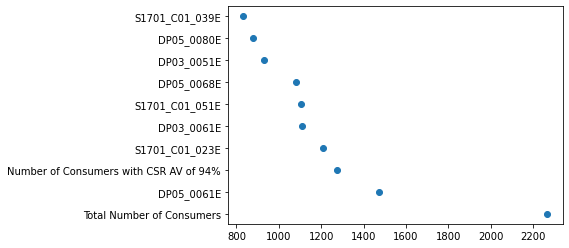

In [6]:
plt.scatter(param_df,param_df.index)

alpha_value: 50 mse 31150244.325549964


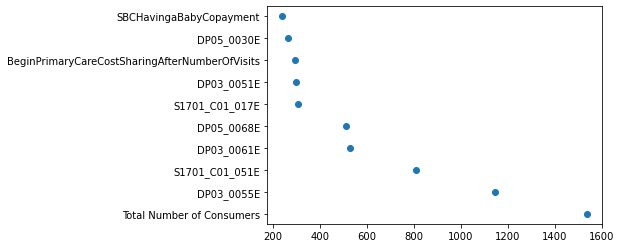

alpha_value: 100 mse 30769424.741030946


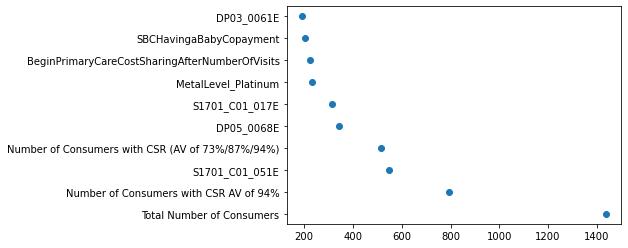

alpha_value: 150 mse 30371657.137911372


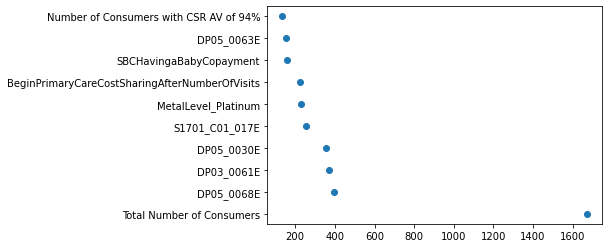

alpha_value: 200 mse 30261077.820271026


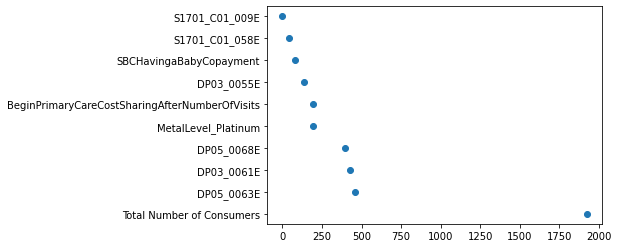

In [7]:
# Vary alpha values
a = [50,100,150,200]
for i in a: 
    lasso = sm.OLS(y_train, sm.add_constant(x_train)).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = lasso.predict(sm.add_constant(x_test))
    print('alpha_value:', i, 'mse', ((y_test.ravel() - y_pred)**2).mean()) 
    param_df = pd.DataFrame(lasso.params,columns=['coefficients']).sort_values(by=['coefficients'], ascending=False).head(10)
    plt.scatter(param_df,param_df.index)
    plt.show()

In [8]:
model = XGBRegressor(n_estimators=x_train.shape[1], max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=184, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(x_test.shape[0],1)
print('mse', ((y_test.ravel() - y_pred)**2).mean()) 

mse 56124014.4198123
